In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

/var/folders/gp/n7ttdtg56pg0s6ydv9zj9wth0000gn/T/ipykernel_34587/1543584708.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
def printMetrics(test, pred): 
    cm = confusion_matrix(test,pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
    cm_display.plot()
    print(f"accuracy: {accuracy_score(test, pred)}")
    print(f"f1_score: {f1_score(test, pred)}")
    print(f"precision_score: {precision_score(test, pred)}")
    print(f"recall: {recall_score(test, pred)}")

In [4]:
df = pd.read_csv("datasource/bank_data_after_fe.csv")

In [5]:
target_value = "y"

In [6]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=target_value),
    df[target_value],
    test_size=0.2,
    stratify=df[target_value],
    random_state=42,
)

In [7]:
from sklearn.utils import compute_class_weight


weights = compute_class_weight(class_weight="balanced",classes= np.unique(y_train), y = y_train)
weights = {0:weights[0], 1:weights[1]}

# Base

In [10]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


estimators1 = [("LogisticRegression", LogisticRegression(max_iter=1000,solver="liblinear", penalty="l1", class_weight=weights)),
              ("DecisionTree", DecisionTreeClassifier(max_depth=6, min_samples_leaf=20, class_weight=weights)),
              ("Gradient", GradientBoostingClassifier(random_state=42, learning_rate=0.13, min_samples_split=6)),
              ("RandomForestClassifier",  RandomForestClassifier(random_state= 42,n_estimators = 1000, n_jobs = -1)),
              ("XGBClassifier", XGBClassifier(random_state=42, n_estimators=1000, learning_rate=0.3, booster="gbtree", max_depth=5)),
             ]

In [83]:
results = pd.DataFrame(columns=["estimator", "accuracy","f1","precision","recall" , "roc_auc"])
resultsT = pd.DataFrame(columns=["estimator", "stat", "score"])

In [84]:
from sklearn.ensemble import StackingClassifier

estimators = estimators1.copy()

estimators.append(("Stacking",StackingClassifier(estimators=estimators1, final_estimator=LogisticRegression(solver="liblinear", penalty="l1", class_weight={0:1, 1:2.6}))))#1,2)

In [85]:
from sklearn.metrics import roc_auc_score

e_names = []
scores_fun = [accuracy_score, f1_score, precision_score, recall_score, roc_auc_score]
scores = [[] for i in range(2)]

for name,es in estimators:
    es.fit(X_train,y_train)
    y_hat = es.predict(X_test)
    for i, fun in enumerate(scores_fun):
        e_names.append(name)
        scores[0].append(fun.__name__)
        scores[1].append(fun(y_test,y_hat))

resultsT["estimator"] = e_names
resultsT["stat"] = scores[0]
resultsT["score"] = scores[1]

resultsT.head(10)

,estimator,stat,score
0,LogisticRegression,accuracy_score,0.809392
1,LogisticRegression,f1_score,0.517483
2,LogisticRegression,precision_score,0.364532
3,LogisticRegression,recall_score,0.891566
4,LogisticRegression,roc_auc_score,0.845159
5,DecisionTree,accuracy_score,0.759669
6,DecisionTree,f1_score,0.456250
7,DecisionTree,precision_score,0.308017
8,DecisionTree,recall_score,0.879518
9,DecisionTree,roc_auc_score,0.811834


<Axes: xlabel='stat', ylabel='score'>

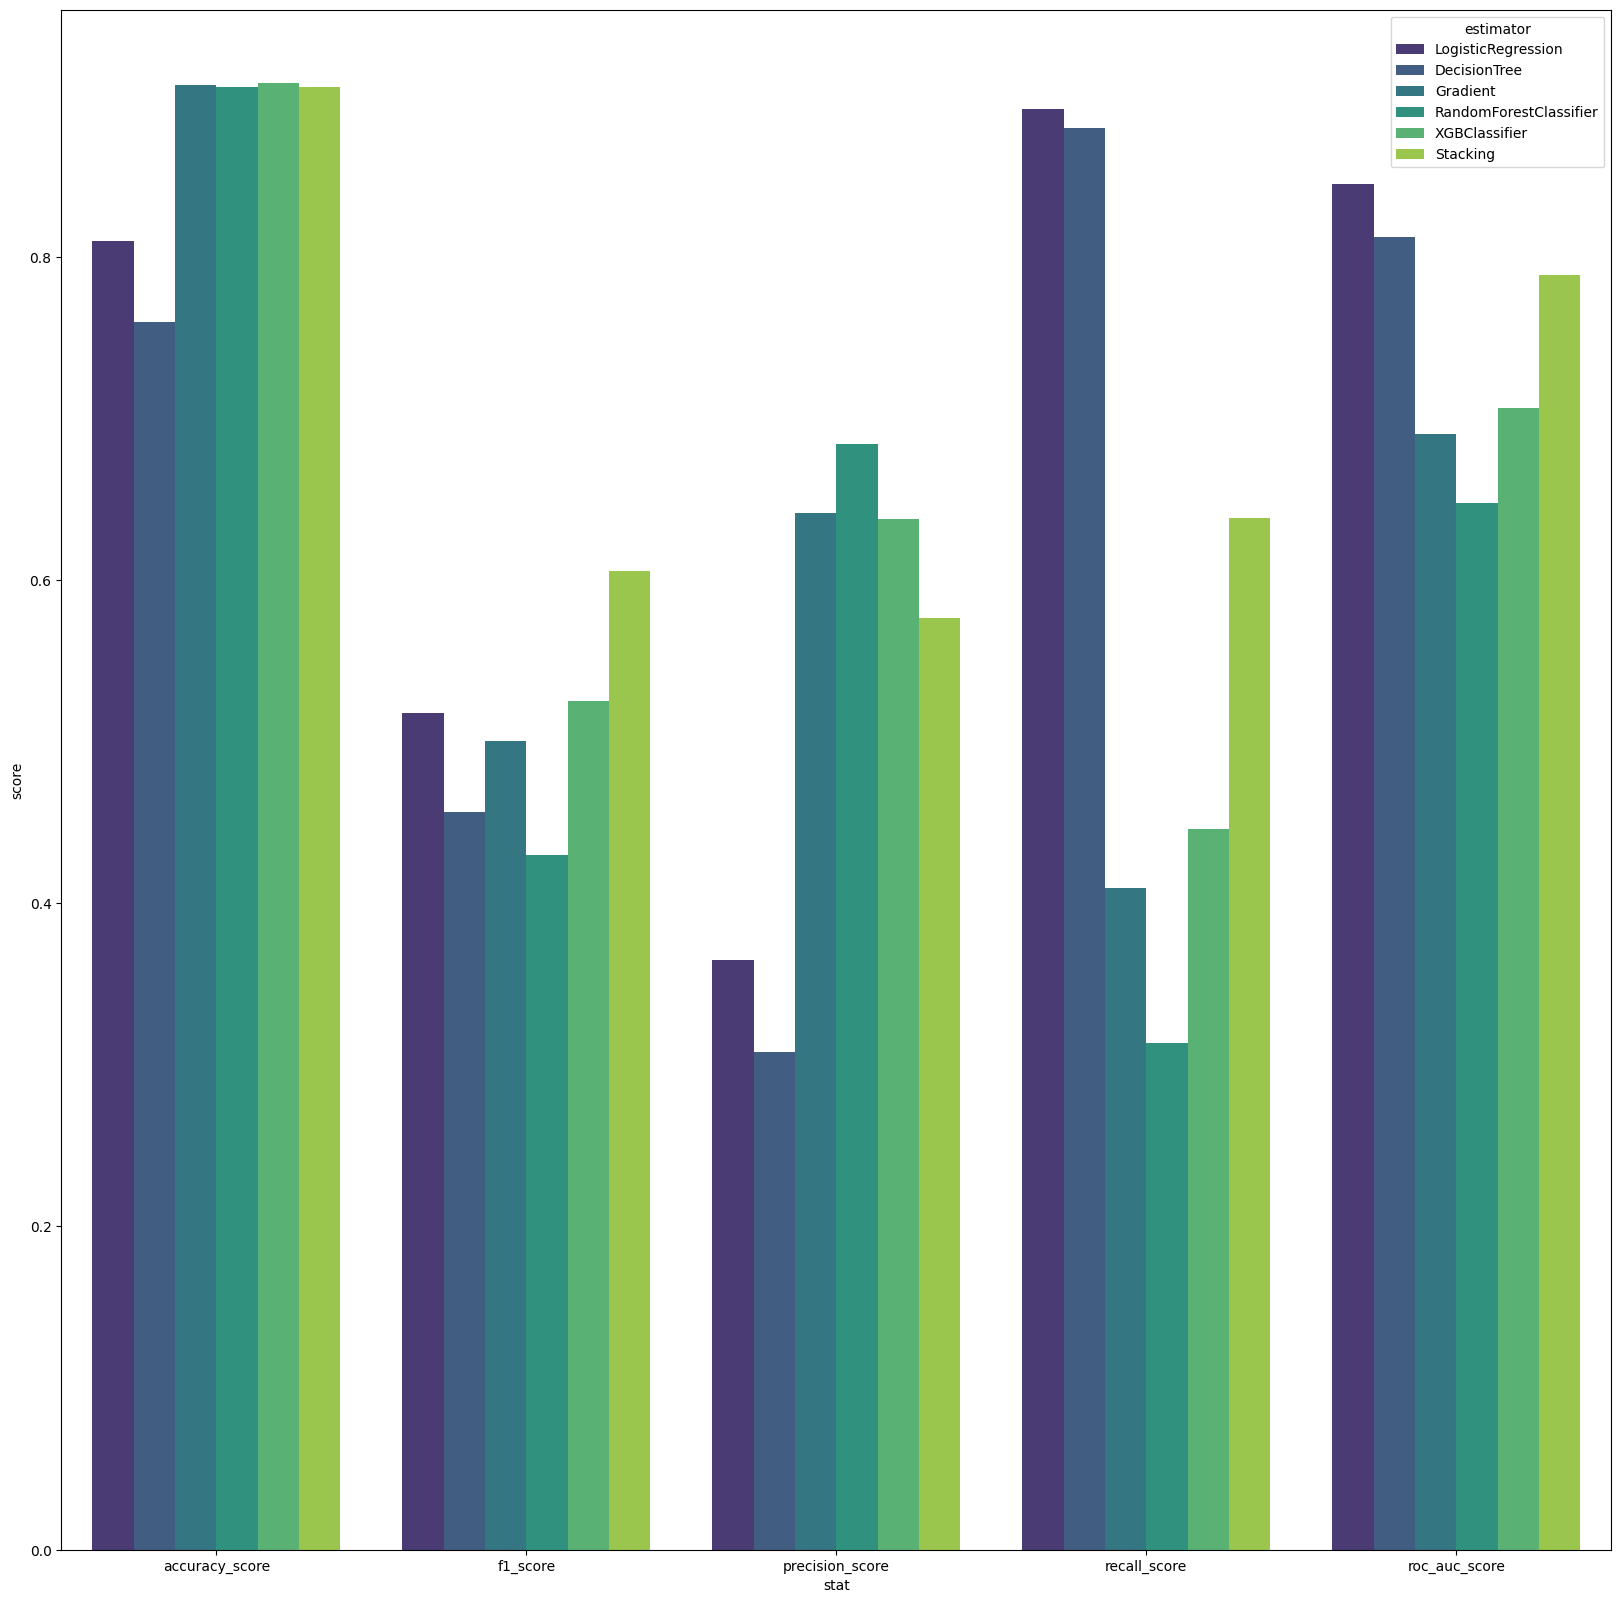

In [86]:
plt.figure(figsize=(20,20))
sns.barplot(resultsT,x = "stat", y = "score", hue="estimator", palette="viridis")

# Tuning

In [15]:
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import StackingClassifier

In [16]:

best_tree = DecisionTreeClassifier(class_weight = 'balanced',
                                    criterion = 'log_loss', 
                                    max_depth= 11, 
                                    max_features = None, 
                                    min_samples_leaf = 4, 
                                    min_samples_split= 15)
best_lr = LogisticRegression(C= 1.49816047538945, 
                             class_weight= 'balanced',
                             intercept_scaling= 1.834347898661638,
                             max_iter= 121,
                             penalty= 'l1',
                             solver= 'liblinear')
best_svc = SVC(class_weight= 'balanced', 
               coef0= -0.6334729623490836, 
               decision_function_shape= 'ovr', 
               degree= 1, 
               gamma= 'auto', 
               kernel= 'linear', 
               shrinking= False) 
best_gb = GradientBoostingClassifier(init=DummyClassifier(strategy='stratified'), 
                                     learning_rate= 2.0481046642919774, 
                                     loss= 'exponential', 
                                     max_depth= 4, 
                                     max_features= 'log2', 
                                     min_samples_leaf= 9, 
                                     min_samples_split= 21, 
                                     n_estimators= 556, 
                                     subsample= 0.8)
best_rf = RandomForestClassifier(class_weight = 'balanced_subsample',
                                 criterion = 'entropy',
                                 max_depth = 10,
                                 max_features = 'sqrt',
                                 min_samples_leaf = 3,
                                 min_samples_split = 17,
                                 oob_score = True)
best_xgb = XGBClassifier(booster= 'gbtree', 
                         eta= 0.10987358313376537,
                         max_delta_step= 1.446953199095078, 
                         max_depth= 4, 
                         min_child_weight= 1.666061864206202, 
                         objective= 'binary:logistic', 
                         scale_pos_weight= 7.671462829736211, 
                         tree_method= 'exact')

In [17]:
estimators1 = [best_tree,best_lr,best_gb,best_rf,best_svc,best_xgb]

for i,e in enumerate(estimators1):
    estimators1[i] = (e.__class__.__name__, e)

In [18]:
clf = StackingClassifier(estimators=[estimators1[3], estimators1[5]], 
                         final_estimator=LogisticRegression(solver="liblinear", penalty="l1", class_weight={0:1, 1:2.6}),
                         cv = 3)

In [19]:
estimators = estimators1.copy()
estimators.append(("Stacking: fr + xgb", clf))

In [95]:
resultsT = pd.DataFrame(columns=["estimator", "stat", "score"])

from sklearn.metrics import roc_auc_score

e_names = []
scores_fun = [accuracy_score, f1_score, precision_score, recall_score, roc_auc_score]
scores = [[] for i in range(2)]

for name,es in estimators:
    es.fit(X_train,y_train)
    y_hat = es.predict(X_test)
    for i, fun in enumerate(scores_fun):
        e_names.append(name)
        scores[0].append(fun.__name__)
        scores[1].append(fun(y_test,y_hat))

resultsT["estimator"] = e_names
resultsT["stat"] = scores[0]
resultsT["score"] = scores[1]

resultsT.head(10)

,estimator,stat,score
0,DecisionTreeClassifier,accuracy_score,0.795580
1,DecisionTreeClassifier,f1_score,0.482517
2,DecisionTreeClassifier,precision_score,0.339901
3,DecisionTreeClassifier,recall_score,0.831325
4,DecisionTreeClassifier,roc_auc_score,0.811138
5,LogisticRegression,accuracy_score,0.809392
6,LogisticRegression,f1_score,0.517483
7,LogisticRegression,precision_score,0.364532
8,LogisticRegression,recall_score,0.891566
9,LogisticRegression,roc_auc_score,0.845159


<Axes: xlabel='stat', ylabel='score'>

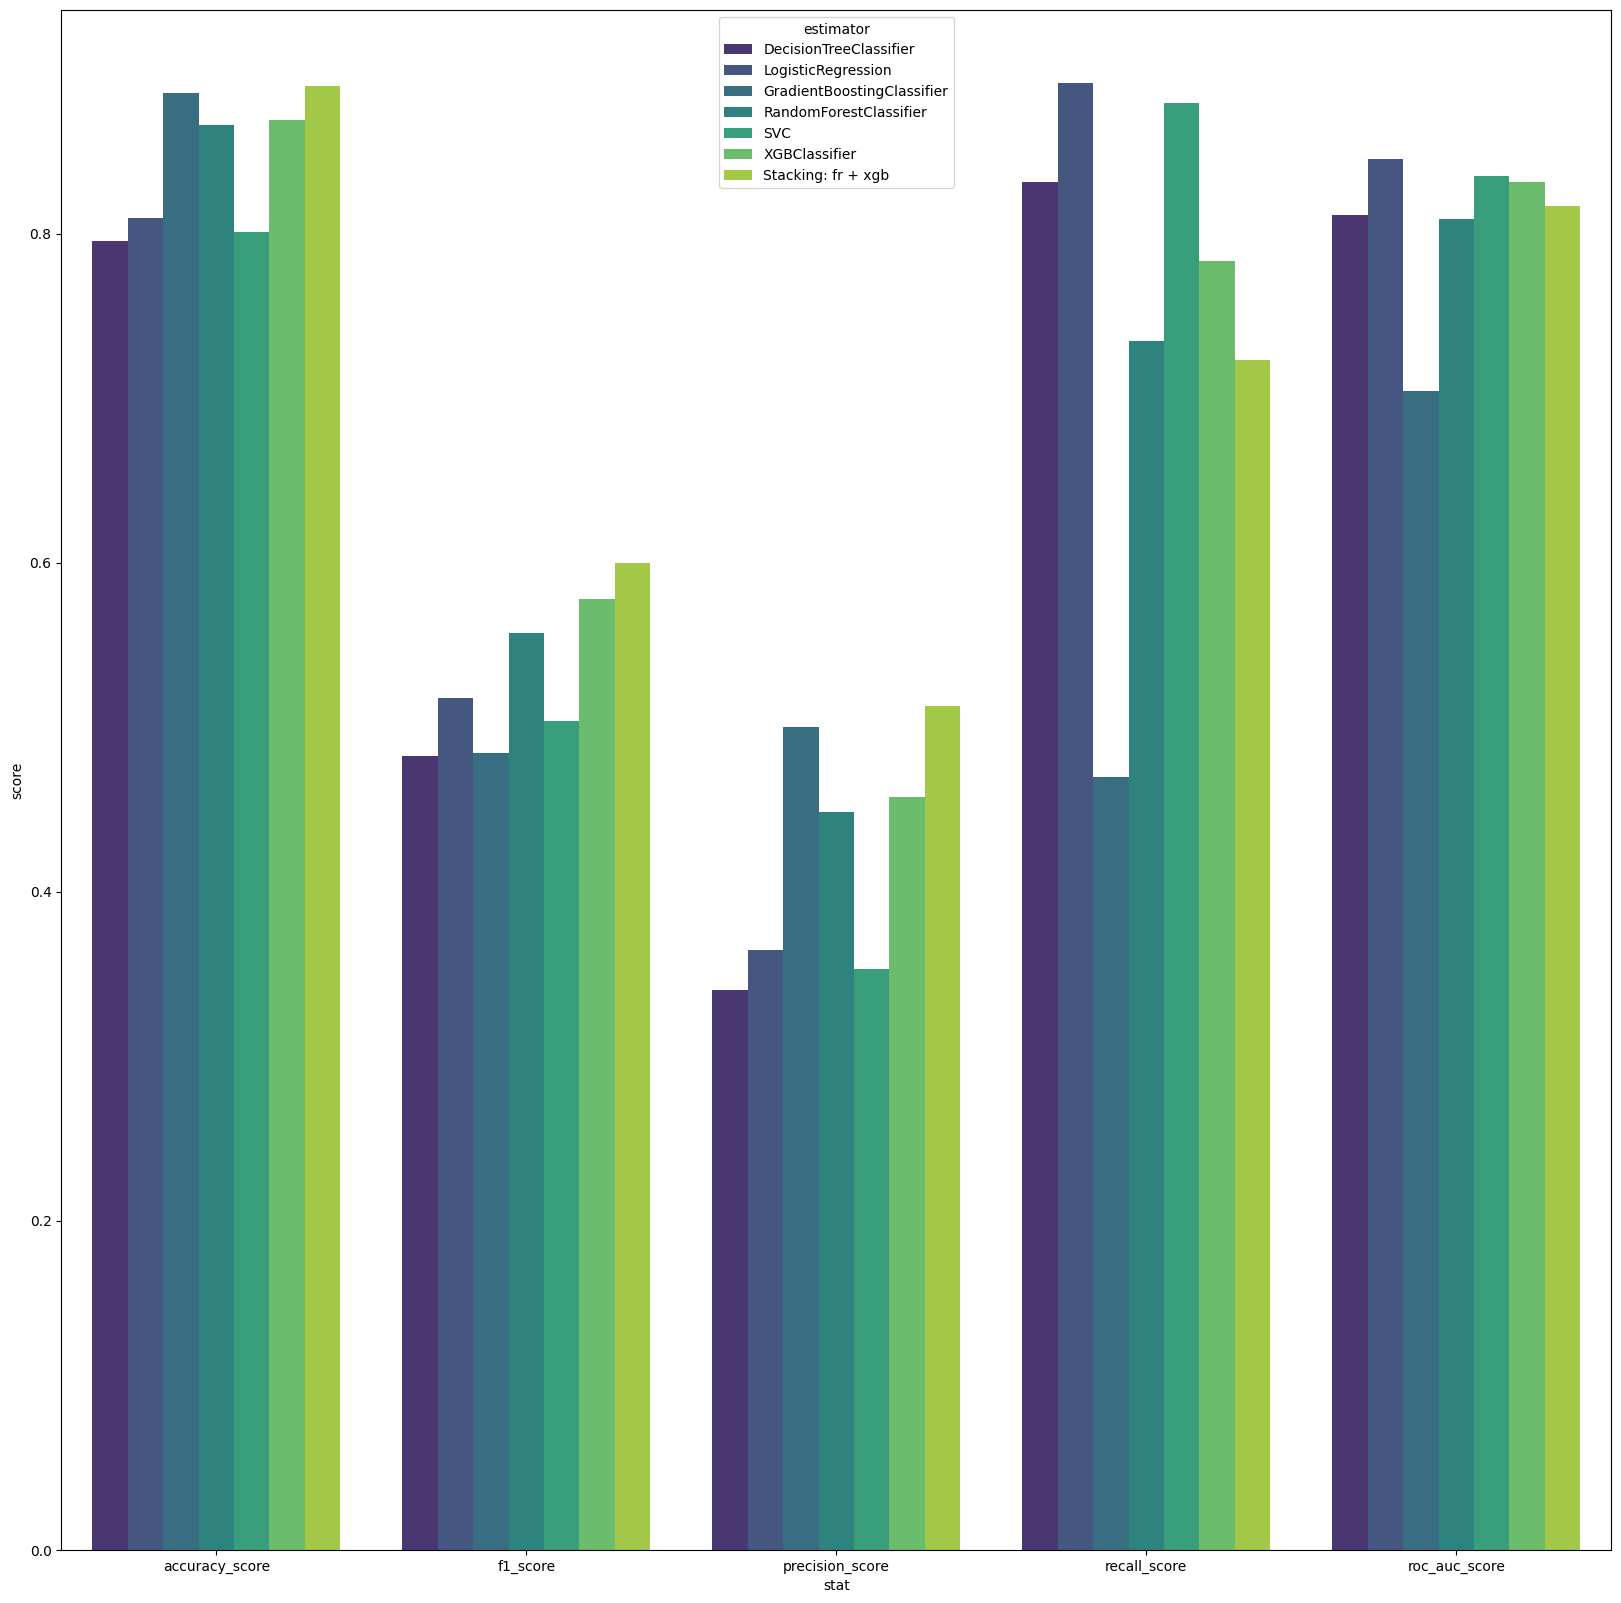

In [96]:
plt.figure(figsize=(20,20))
sns.barplot(resultsT,x = "stat", y = "score", hue="estimator", palette="viridis")

DecisionTreeClassifier mean-0.451 std-0.029
LogisticRegression mean-0.484 std-0.025
RandomForestClassifier mean-0.543 std-0.032
XGBClassifier mean-0.574 std-0.030
Stacking: fr + xgb mean-0.573 std-0.034


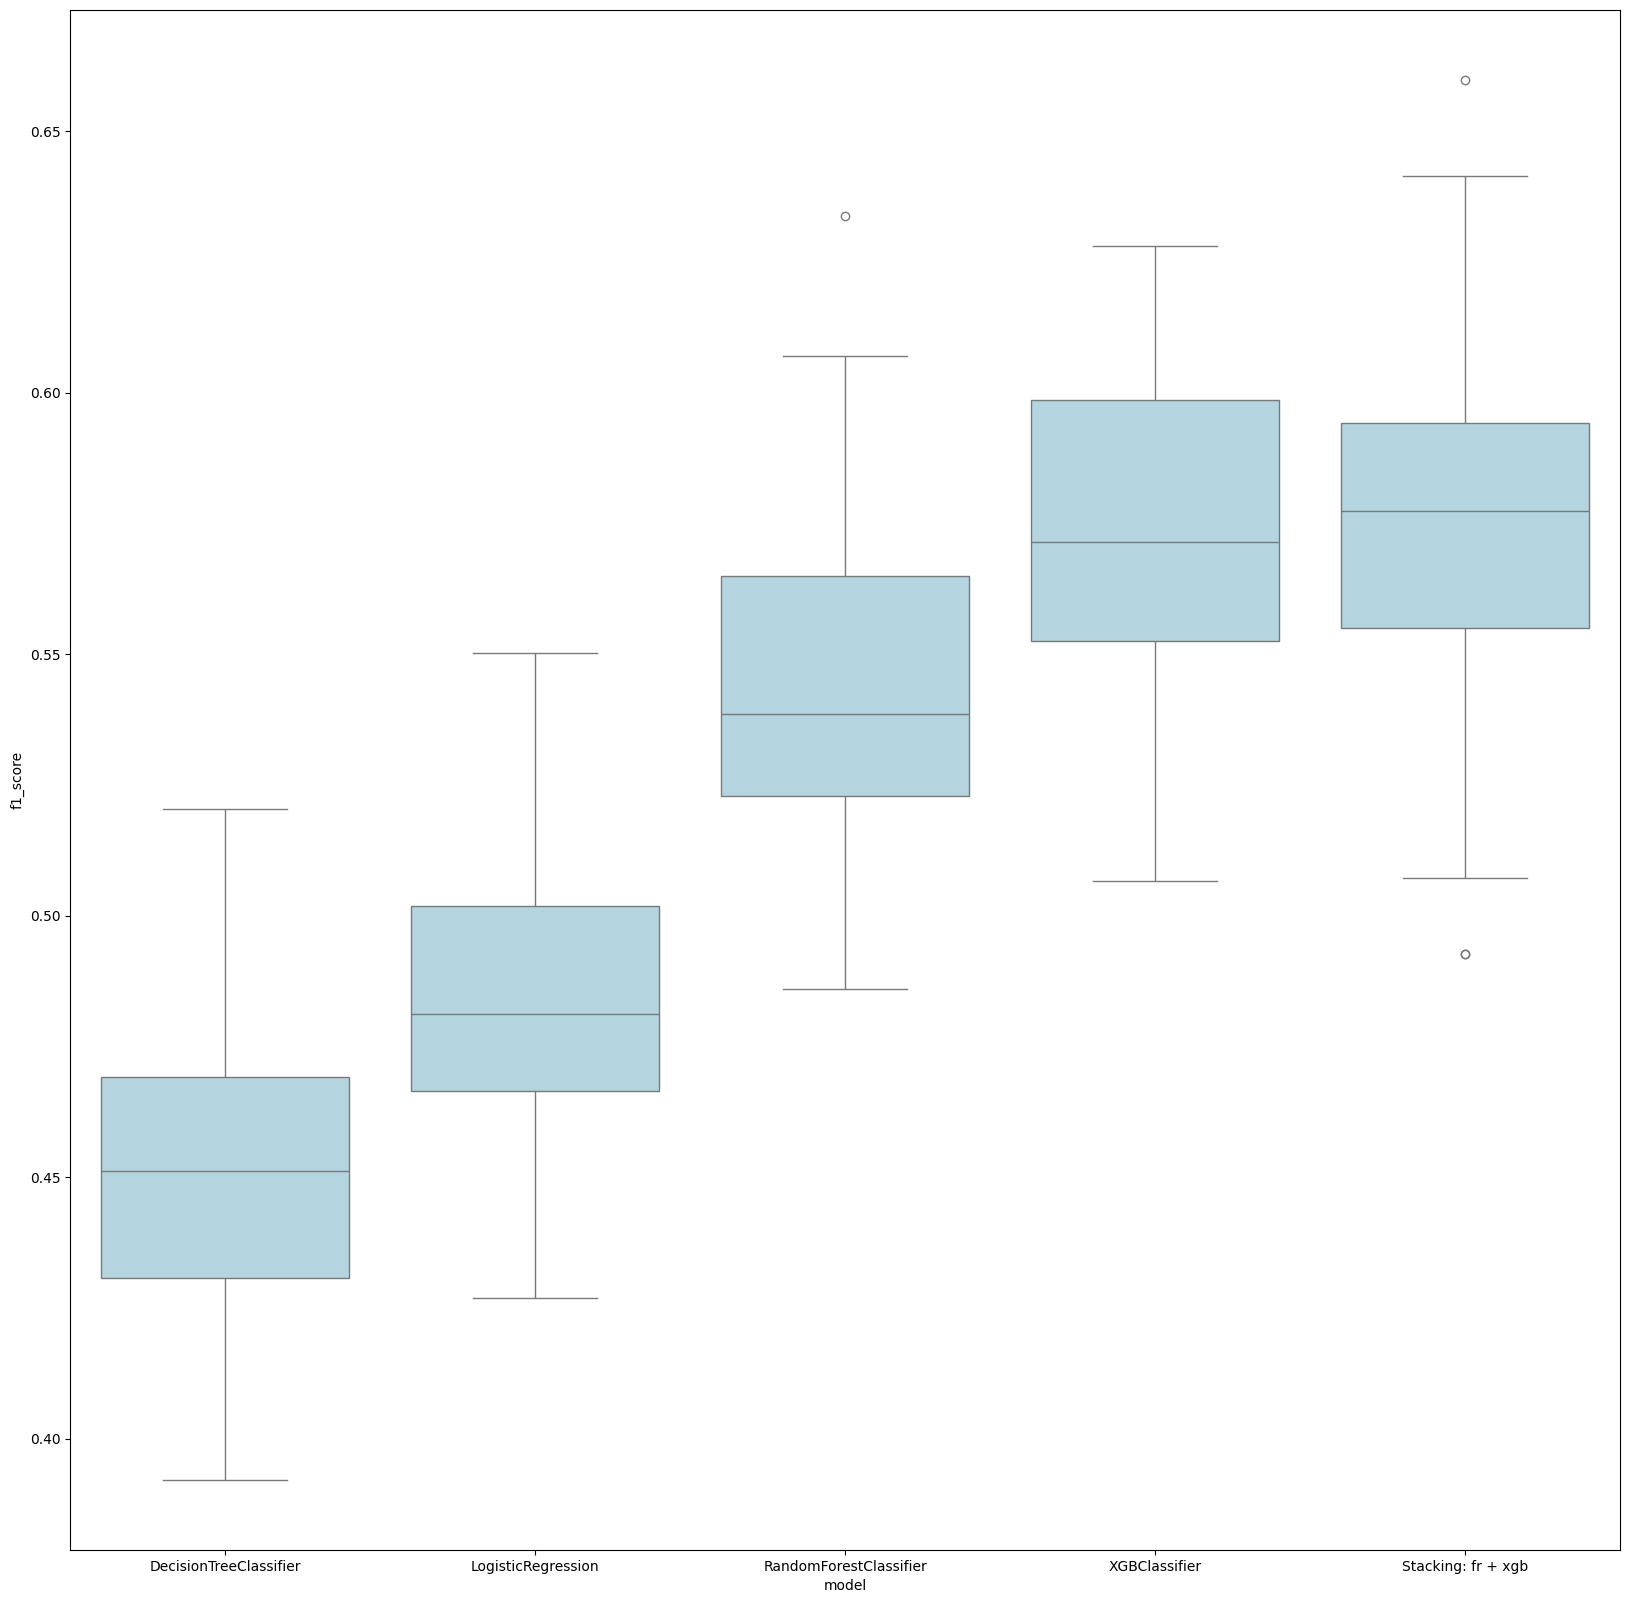

In [103]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score


def evaluate_model_f1(model, X, y):
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=11, random_state=1)
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')

    return scores

models = dict()
for e in estimators:
    if e[0] == "SVC" or e[0] == "GradientBoostingClassifier": continue
    models[e[0]] = e[1]
X = df.drop(columns=target_value)
y = df[target_value]

results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model_f1(model, X, y)
    results.append(scores)
    names.append(name)
    print('%8s mean-%.3f std-%.3f' % (name, np.mean(scores), np.std(scores)))

res_df = pd.DataFrame(results)
res_df["model"] = names
res_df = res_df.melt(id_vars="model", var_name="cv", value_name="f1_score")

plt.figure(figsize=(20,20))
sns.boxplot(res_df, x="model", y="f1_score", color="lightblue")
plt.show()